In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import load_digits
from scipy.stats import ortho_group

### Experiments with Marchenko-Pastur Synthetic Dataset

In [2]:
# returns 1 / n * Hessian of a matrix
def n_Hessian(A):
  n = len(A) # number of rows of A
  return 1 / n * np.matmul(A.T, A)

In [3]:
# least squares gradient
# input A, b, n
def gradient(A, b, vec):
  n = len(A)
  grad = 1 / n * np.expand_dims(np.squeeze(np.matmul((np.matmul(A, vec) - b).T, A)), axis=1)
  return grad

In [4]:
# ground truth least squares optimal solution
def least_squares_min(A, b):
  H = np.matmul(A.T, A)
  return np.matmul(np.matmul(np.linalg.inv(H), A.T), b)

In [5]:
# marchenko-pastur distribution for first synthetic dataset, r < 1
def marchenko_pastur_distr(lambd, r):
  L = (1 + np.sqrt(r))**2
  l = (1 - np.sqrt(r))**2

  def m0(a):
    return (a > 0).astype(int)

  output = np.sqrt(m0((L - lambd)) * m0(lambd - l))

  if output != 0:
    output = output / (2 * np.pi * r * lambd)

  return output

In [6]:
# plots spectrum of Hessian of A alongside Marchenko-Pastur distribution
def spectral_mp_distr(A, ratio, n_bins, x_max):
  H = n_Hessian(A)
  eigval, eigvec = np.linalg.eigh(H)
  plt.hist(eigval, bins=n_bins, density = True)
  lambd = np.linspace(0, 50, 10000)
  plt.ylim([0, 1])
  plt.xlim([0, x_max])
  output = [marchenko_pastur_distr(el, ratio) for el in lambd]
  plt.plot(lambd, output, label = 'Marchenko-Pastur Distribution')
  plt.ylabel('Eigenvalue Density')
  plt.title('Spectral Distribution (MP Synthetic Dataset)')
  plt.legend()
  plt.show()

In [7]:
# marchenko-pastur acceleration
def marchenko_pastur(A, b, n_iter, x_0):
  # parameters
  d = len(A[0,:])
  n = len(A)
  H = n_Hessian(A)
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval) # n times this?

  # MP parameters
  r = d / n
  sigma_2 = 1
  rho = (1 + r) / np.sqrt(r)
  
  # update vector of deltas
  delta_0 = 0
  delta_1 = 1 / (-1 * rho - delta_0)
  delta = [delta_0, delta_1]

  # initial values
  # next step
  x_1 = x_0 - 1 / ((1 + r) * sigma_2) * gradient(A, b, x_0)
  # update vector of values
  values = [x_0, x_1]

  # acceleration
  for iter in range(2, n_iter):
    # compute current delta
    delta_curr = 1 / (-1 * rho - delta[iter - 1])
    delta.append(delta_curr)
    # compute current value
    x_curr = values[iter - 1] + (1 + rho * delta[iter]) * (values[iter - 2] - values[iter - 1]) + delta[iter] * gradient(A, b, values[iter - 1]) / (sigma_2 * np.sqrt(r))
    values.append(x_curr)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)

  w = least_squares_min(A, b)
  obj_sub = np.array([np.sum((vec - w)**2) for vec in values])
  return np.squeeze(obj_sub)

In [8]:
# simplified marchenko-pastur distribution
def marchenko_pastur_simp(A, b, n_iter, x_0):
  # parameters
  d = len(A[0,:])
  n = len(A)
  H = n_Hessian(A)

  r = d / n
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)
  sigma_2 = 1

  # initial guess
  # next step
  x_1 = x_0 - 1 / ((1 + r) * sigma_2) * gradient(A, b, x_0)
  # update vector of values
  values = [x_0, x_1]

  for iter in range(2, n_iter):
    # compute current value
    x_curr = values[iter - 1] - min(1 / r, r) * (values[iter - 2] - values[iter - 1]) - 1 / sigma_2 * min(1, 1 / r) * gradient(A, b, values[iter - 1])
    values.append(x_curr)

  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  
  w = least_squares_min(A, b)
  obj_sub = np.array([np.sum((vec - w)**2) for vec in values])
  return np.squeeze(obj_sub)

In [9]:
# generate many synthetic datasets and apply marchenko-pastur acceleration
def generate_mp(n, d, n_samp, n_iter, x_0):
  for index in range(n_samp):
    A = np.random.normal(0.0, 1.0, size=(n, d)) # generate matrix
    b = np.random.normal(0.0, 1.0, size=(n, 1)) # generate vector
    obj = marchenko_pastur(A, b, n_iter, x_0)

    x = range(n_iter)
    plt.title('Marchenko-Pastur Acceleration')
    plt.plot(x, obj, color = 'lightgray')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([1e-10, 1])
    plt.yscale('log')

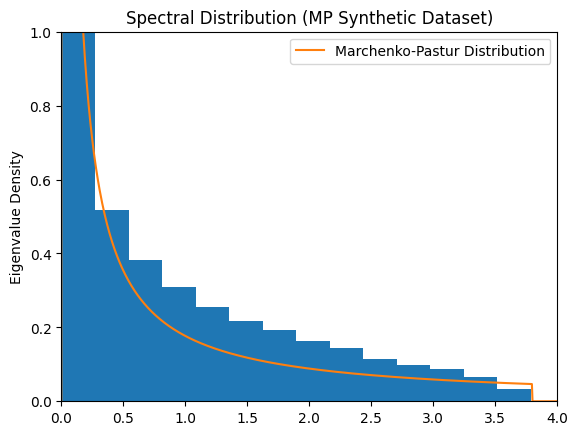

In [12]:
# synthesize dataset with eigenvalues following Marchenko-Pastur distribution
d = 900
n = 1000

A = np.random.normal(0.0, 1.0, size=(n, d)) # generate matrix
b = np.random.normal(0.0, 1.0, size=(n, 1)) * 0 # generate vector

spectral_mp_distr(A, 0.9, 'auto', 4)

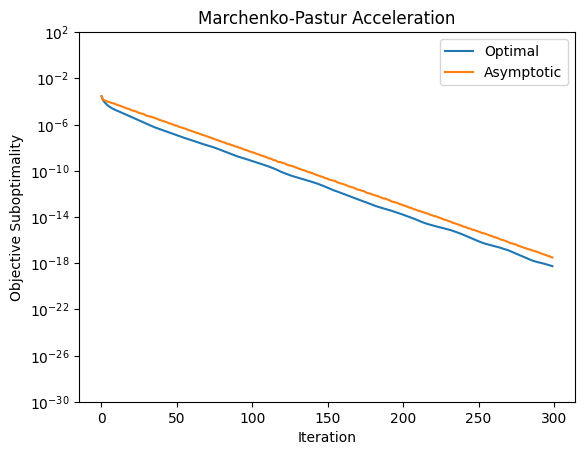

In [13]:
# plot convergence rate
x_0 = np.random.random(size = (d, 1)) * 1e-3
n_iter = 300
H = n_Hessian(A)
mp_obj = marchenko_pastur(A, b, n_iter, x_0)
mp_simp_obj = marchenko_pastur_simp(A, b, n_iter, x_0)
x = range(300)
plt.plot(x, mp_obj, label = 'Optimal')
plt.plot(x, mp_simp_obj, label = 'Asymptotic')
plt.title('Marchenko-Pastur Acceleration')
plt.xlabel('Iteration')
plt.ylabel('Objective Suboptimality')
plt.ylim([1e-30, 100])
plt.yscale('log')
plt.legend()
plt.show()

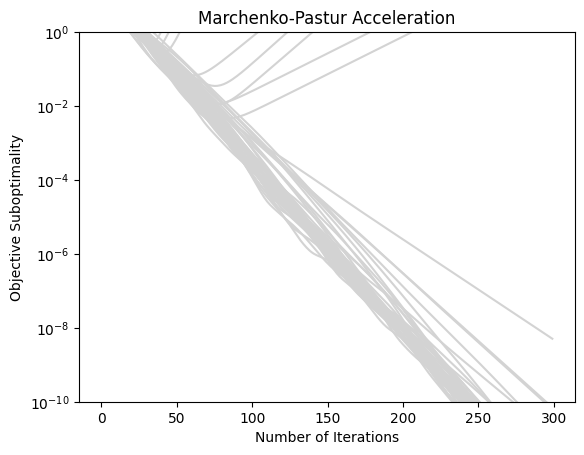

In [14]:
# generate many datasets
n_samp = 50
n_iter = 300
x_0 = np.random.random(size = (d, 1)) * 1e-3
generate_mp(n, d, n_samp, n_iter, x_0)

In [15]:
# generate many synthetic datasets and apply marchenko-pastur acceleration
def generate_mp_simp(n, d, n_samp, n_iter, x_0):
  for index in range(n_samp):
    A = np.random.normal(0.0, 1.0, size=(n, d)) # generate matrix
    b = np.random.normal(0.0, 1.0, size=(n, 1)) # generate vector
    obj = marchenko_pastur_simp(A, b, n_iter, x_0)

    x = range(n_iter)
    plt.title('Marchenko-Pastur Acceleration (Asyptotic)')
    plt.plot(x, obj, color = 'lightgray')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([1e-10, 1])
    plt.yscale('log')

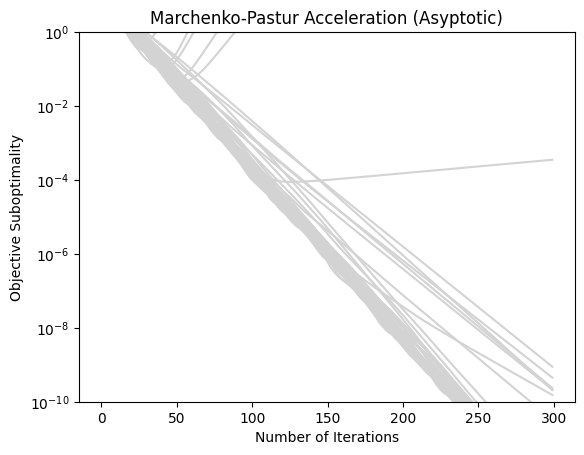

In [16]:
# generate many datasets
n_samp = 50
n_iter = 300
x_0 = np.random.random(size = (d, 1)) * 1e-3
generate_mp_simp(n, d, n_samp, n_iter, x_0)

### Experiments with Exponential Synthetic Dataset

In [17]:
# gradient for x^T H x
def gradient(H, x):
  return H @ x

In [18]:
# exponential distribution
def expon_distr(lambd, lambda_0):
  return 1 / lambda_0 * math.exp(-1 * lambd / lambda_0)

In [19]:
# plots spectrum of Hessian alongside Exponential distribution
def spectral_exp_distr(H, lambda_0, n_bins, x_min, x_max, y_min, y_max):
  eigval, _ = np.linalg.eigh(H)
  plt.hist(eigval, bins = n_bins, density = True)
  lambd = np.linspace(0, 50, 10000)
  plt.ylim([y_min, y_max])
  plt.xlim([x_min, x_max])
  output = [expon_distr(el, lambda_0) for el in lambd]
  plt.plot(lambd, output, label = 'Exponential Distribution')
  plt.title('Spectral Distribution (Exponential Synthetic Dataset)')
  plt.ylabel('Eigenvalue Density')
  plt.legend()
  plt.show()

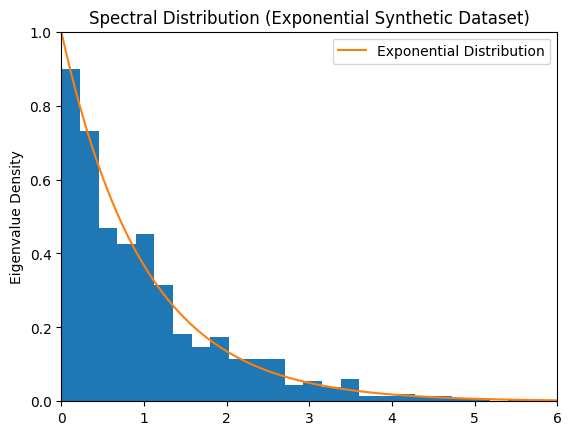

In [20]:
d = 900

# generate matrix
D = np.random.exponential(scale = 1, size = (d, d))
D = np.diag(np.diag(D))
P = ortho_group.rvs(d)
H = P.T @ D @ P

spectral_exp_distr(H, 1, 'auto', 0, 6, 0, 1)

In [21]:
def exponential(H, n_iter, x_0):
  # hyperparameters
  lambda_0 = d / H.trace()
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)

  # initial guess
  x_1 = x_0 - lambda_0 / 2 * gradient(H, x_0)
  values = [x_0, x_1]
  for iter in range(2, n_iter):
    x_curr = values[iter - 1] + (iter - 1) / (iter + 1) * (values[iter - 1] - values[iter - 2]) - lambda_0 / (iter + 1) * gradient(H, values[iter - 1])
    values.append(x_curr)

  values = [np.squeeze(vec) for vec in values]
  
  obj_sub = np.array([np.sum(vec**2) for vec in values])
  return np.squeeze(obj_sub)

In [22]:
# generate many synthetic datasets and apply exponential acceleration
def generate_exp(d, n_samp, n_iter, x_0):
  for index in range(n_samp):
    D = np.random.exponential(scale = 1, size = (d, d)) # generate matrix
    D = np.diag(np.diag(D))
    P = ortho_group.rvs(d)
    H = P.T @ D @ P
    obj = exponential(H, n_iter, x_0)

    x = range(n_iter)
    plt.title('Exponential Acceleration')
    plt.plot(x, obj, color = 'lightgray')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([1e-10, 1])
    plt.yscale('log')

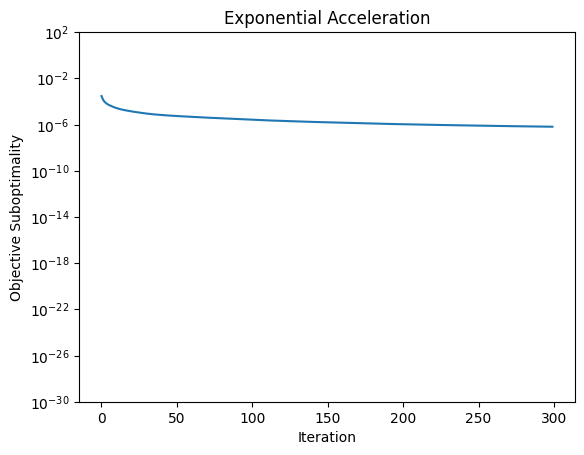

In [23]:
# plot convergence rate
x_0 = np.random.random(size = (d, 1)) * 1e-3
exp_obj = exponential(H, 300, x_0)
x = range(300)
plt.plot(x, exp_obj)
plt.title('Exponential Acceleration')
plt.xlabel('Iteration')
plt.ylabel('Objective Suboptimality')
plt.ylim([1e-30, 100])
plt.yscale('log')

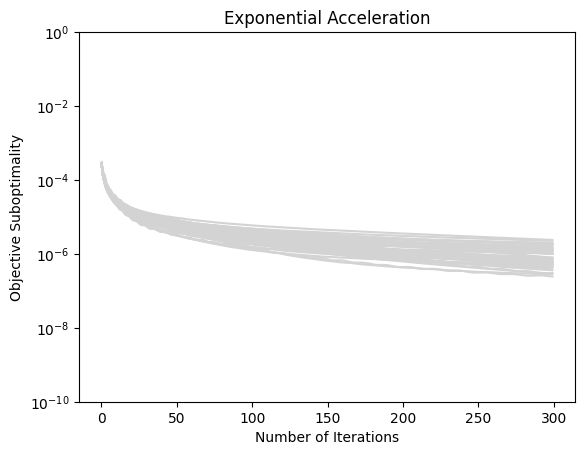

In [24]:
# generate datasets
n_samp = 50
n_iter = 300
x_0 = np.random.random(size = (d, 1)) * 1e-3
generate_exp(d, n_samp, n_iter, x_0)

### Experiments with Uniform Synthetic Dataset

In [25]:
def spectral_unif_distr(H, l, L, n_bins, pad):
  eigval, _ = np.linalg.eigh(H)
  plt.hist(eigval, bins = n_bins, density = True)
  lambd = np.linspace(l, L, 10000)
  plt.ylim([0, 1 / (L - l) + pad])
  plt.xlim([l, L])
  output = [1 / (L - l) for el in lambd]
  plt.plot(lambd, output, label = 'Uniform Distribution')
  plt.title('Spectral Distribution (Uniform Synthetic Dataset)')
  plt.ylabel('Eigenvalue Density')
  plt.legend()
  plt.show()

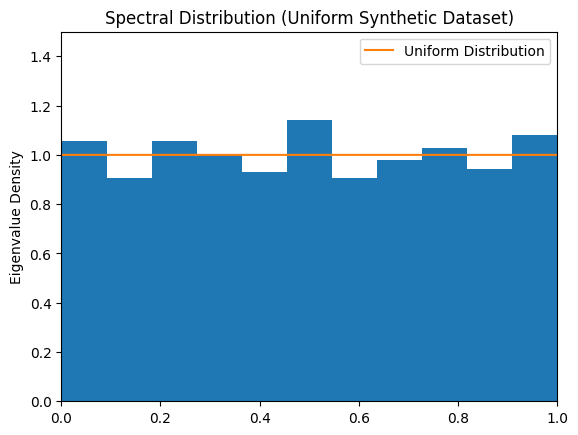

In [26]:
d = 900

# generate matrix
D = np.random.uniform(low = 0, high = 1, size = (d, d)) # generate matrix
D = np.diag(np.diag(D))
P = ortho_group.rvs(d)
H = P.T @ D @ P

spectral_unif_distr(H, 0, 1, 'auto', 0.5)

In [27]:
def uniform(H, n_iter, x_0):
  # set up
  eigval, eigvec = np.linalg.eigh(H)
  L = max(eigval) # largest eigenvalue
  l = min(eigval) # minimum eigenvalue

  # initial guess
  x_1 = x_0

  values = [x_0, x_1]
  d_1 = -1 * (L + l) / 2
  d_list = [0, d_1]
  e_1 = -1 * (L - l)**2 / (4 * d_1 * (4 - 1))
  e_list = [0, e_1]
  m_1 = 1 / (d_1 - e_1)
  m_list = [0, m_1]

  for iter in range(2, n_iter):
    # compute d
    d_curr = -1 * (L + l) / 2 + e_list[iter - 1]
    d_list.append(d_curr)
    # compute e
    e_curr = -1 * (L - l)**2 * (iter**2) / (4 * d_curr * (4 * iter**2 - 1))
    e_list.append(e_curr)
    # compute m
    m_curr = 1 / (d_curr - e_curr + m_list[iter - 1] * d_curr * e_list[iter - 1])
    m_list.append(m_curr)

    # compute current value
    x_curr = values[iter - 1] + (1 - m_curr * (d_curr - e_curr)) * (values[iter - 2] - values[iter - 1]) + m_curr * gradient(H, values[iter - 1])
    values.append(x_curr)
  
  values = [np.squeeze(vec) for vec in values]
  
  obj_sub = np.array([np.sum((vec)**2) for vec in values])
  return np.squeeze(obj_sub)

In [28]:
# generate many synthetic datasets and apply exponential acceleration
def generate_uniform(d, n_samp, n_iter, x_0):
  for index in range(n_samp):
    D = np.random.uniform(low = 0, high = 1, size = (d, d)) # generate matrix
    D = np.diag(np.diag(D))
    P = ortho_group.rvs(d)
    H = P.T @ D @ P
    obj = uniform(H, n_iter, x_0)

    x = range(n_iter)
    plt.title('Uniform Acceleration')
    plt.plot(x, obj, color = 'lightgray')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([1e-10, 1])
    plt.yscale('log')

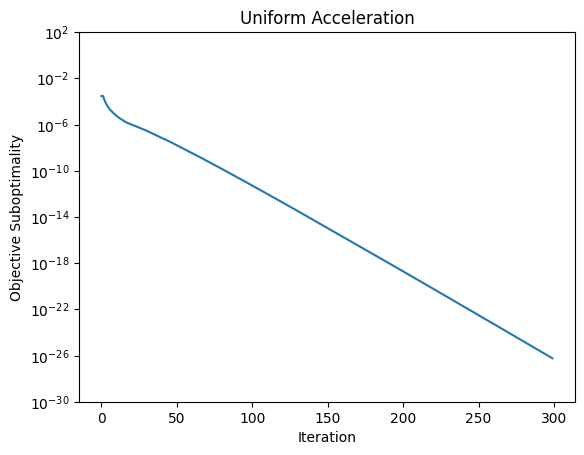

In [30]:
# plot convergence rate
x_0 = np.random.random(size = (d, 1)) * 1e-3
uniform_obj = uniform(H, 300, x_0)
x = range(300)
plt.plot(x, uniform_obj)
plt.title('Uniform Acceleration')
plt.xlabel('Iteration')
plt.ylabel('Objective Suboptimality')
plt.ylim([1e-30, 100])
plt.yscale('log')

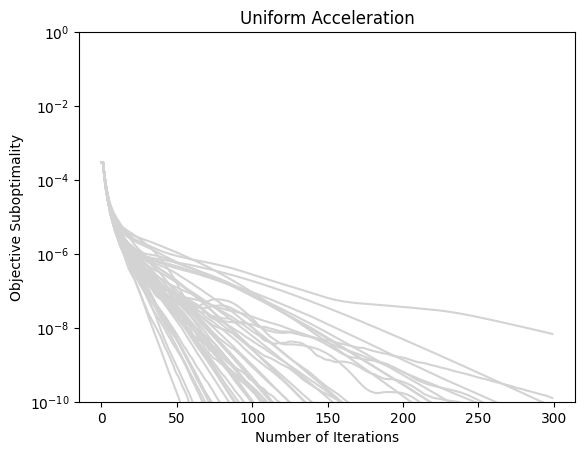

In [31]:
# generate datasets
n_samp = 50
n_iter = 300
x_0 = np.random.random(size = (d, 1)) * 1e-3
generate_uniform(d, n_samp, n_iter, x_0)